# Consignes

- Construisez un modèle KNN au sein d'un pipe line en incluant la normalisation, les polynomials features et le grid search.
- Utilisez la bibliothèque Pycaret pour lancer une série de modèles et les analyser. Comparer les résultats obtenus avec vos autres résultats. 

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score, roc_auc_score,plot_roc_curve, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import shap

In [49]:
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse

In [50]:
df = pd.read_csv("data/intermediate/Telco_post_analysis.csv")

In [51]:
df["Churn"] = LabelEncoder().fit_transform(df["Churn"])
for col in df.drop("customerID",axis=1).columns:
    df[col][(df[col]=="No") | (df[col]=="Male") | (df[col]=="DSL") | (df[col]=="Only Internet")] = 0
    df[col][(df[col]=="Yes") | (df[col]=="Female") | (df[col]=="Fiber optic") | (df[col]=="Phone and Internet")] = 1
    df[col][(df[col]=="No phone service") | (df[col]=="No internet service") | (df[col]=="Only Phone")] = -1
    df[col][df[col] == "Month-to-month"] = 1
    df[col][df[col] == "One year"] = 12
    df[col][df[col] == "Two year"] = 24
    df[col][df[col] == "Mailed check"] = 0
    df[col][df[col] == "Electronic check"] = 1
    df[col][df[col] == "Credit card (automatic)"] = 2
    df[col][df[col] == "Bank transfer (automatic)"] = 3
    df[col] = df[col].astype(float)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [52]:
X = df.drop(["customerID", "Churn"], axis=1)
y = df.Churn

In [53]:
features_standard = df.drop(["customerID","Churn"], axis=1).columns
standard_pipeline = make_pipeline(StandardScaler())

preprocessor = make_column_transformer((standard_pipeline,features_standard))

In [54]:
k_nn = make_pipeline(preprocessor, KNeighborsClassifier())
k_nn.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'kneighborsclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__pipeline', 'columntransformer__pipeline__memory', 'columntransformer__pipeline__steps', 'columntransformer__pipeline__verbose', 'columntransformer__pipeline__standardscaler', 'columntransformer__pipeline__standardscaler__copy', 'columntransformer__pipeline__standardscaler__with_mean', 'columntransformer__pipeline__standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

In [56]:
mlflow.sklearn.autolog()

In [57]:
param_knn = {"kneighborsclassifier__n_neighbors":[5, 8, 12, 15],"kneighborsclassifier__algorithm":["auto","ball_tree", "kd_tree", "brute"],
                       "kneighborsclassifier__metric":["minkowski", "manhattan", "euclidean"],"kneighborsclassifier__leaf_size":[20, 30, 40, 50]}
grid_decision = GridSearchCV(k_nn, param_knn, scoring='roc_auc',cv=5)
grid_decision.fit(X_train, y_train)
grid_decision.best_params_

2022/03/07 14:19:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'aed52c7463f043028b326573517b1f17', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/03/07 14:19:08 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                              ...`
2022/03/07 14:19:08 WARNING mlflow.utils: Truncated the value of the key `param_grid`. Truncated value: `{'kneighborsclassifier__n_neighbors': [5, 8, 12, 15], 'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'kneighborsclassifier__metric': ['minkowski', 'manhattan', 'euclidean'], 'kneighborsclassifier__leaf_size': [20, 30...`
2022/03/07 14:21:59 WARNIN

{'kneighborsclassifier__algorithm': 'kd_tree',
 'kneighborsclassifier__leaf_size': 40,
 'kneighborsclassifier__metric': 'manhattan',
 'kneighborsclassifier__n_neighbors': 15}

In [58]:
param_knn = {"kneighborsclassifier__n_neighbors":[15, 18, 20, 25],"kneighborsclassifier__algorithm":["kd_tree"],
                       "kneighborsclassifier__metric":["manhattan"],"kneighborsclassifier__leaf_size":[35, 40, 55]}
grid_knn = GridSearchCV(k_nn, param_knn, scoring='roc_auc',cv=5)
grid_knn.fit(X_train, y_train)
grid_knn.best_params_

2022/03/07 14:22:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '579baba429c4427eb875c11841817dcd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/03/07 14:22:11 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                              ...`
2022/03/07 14:22:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Apprenant\anaconda3\envs\rb_ds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixD

{'kneighborsclassifier__algorithm': 'kd_tree',
 'kneighborsclassifier__leaf_size': 40,
 'kneighborsclassifier__metric': 'manhattan',
 'kneighborsclassifier__n_neighbors': 25}

In [59]:
param_knn = {"kneighborsclassifier__n_neighbors":np.arange(25,100,1),"kneighborsclassifier__algorithm":["kd_tree"],
                       "kneighborsclassifier__metric":["manhattan"],"kneighborsclassifier__leaf_size":[40]}
grid_knn = GridSearchCV(k_nn, param_knn, scoring='roc_auc',cv=5)
grid_knn.fit(X_train, y_train)
grid_knn.best_params_
k_nn_params = grid_decision.best_params_

2022/03/07 14:22:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6a44603eedb74e32bda0ba59a9ed1954', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/03/07 14:22:37 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                              ...`
2022/03/07 14:22:37 WARNING mlflow.utils: Truncated the value of the key `param_grid`. Truncated value: `{'kneighborsclassifier__n_neighbors': array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, ...`
2022/03/07 14:24:04 WARNIN

In [63]:
k_nn_model = grid_knn.best_estimator_
k_nn_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Service', 'nbr_option_internet'],
      dtype='object'))])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='kd_tree', leaf_size=40,
                                      metric='manhattan', n_neighbors=68))])

In [60]:
def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred)
    recall = recall_score(actual, pred)
    precision = precision_score(actual, pred)
    return accuracy, f1, recall, precision

2022/03/07 14:26:45 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('columntransformer', ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index([...`
2022/03/07 14:26:45 WARNING mlflow.utils: Truncated the value of the key `columntransformer`. Truncated value: `ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['gender', 'SeniorCitize...`
2022/03/07 14:26:45 WARNING mlflow.utils: Truncated the value of the key `columntransformer__transformers`. Truncated value: `[('pipeline', Pipeline(steps=[('standardscaler', StandardScaler())]), Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneServic

  accuracy: 0.7889125799573561
  f1: 0.6013422818791946
  recall: 0.6120218579234973
  precision: 0.5910290237467019
ROC = 0.8361679343632384


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


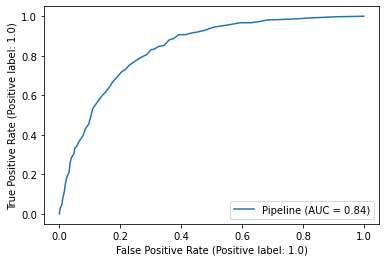

In [68]:
with mlflow.start_run(experiment_id = 1):
    model = k_nn_model.fit(X_train, y_train)
    y_pred = (model.predict_proba(X_test)[:,1] >= 0.48).astype(bool)
    y_pred_proba = model.predict_proba(X_test)
    
    accuracy, f1, recall, precision = eval_metrics(y_test, y_pred)
    print("  accuracy: %s" % accuracy)
    print("  f1: %s" % f1)
    print("  recall: %s" % recall) 
    print("  precision: %s" % precision)  

    print(f'ROC = {roc_auc_score(y_test, y_pred_proba[:,1])}')
    mlflow.log_param("Variables", X_test.columns)
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "model", registered_model_name="KNN")
    else:
        mlflow.sklearn.log_model(model, "model") 

plot_roc_curve(model, X_test, y_test)